# Finding Lane Lines on the Road

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Step 0: Input

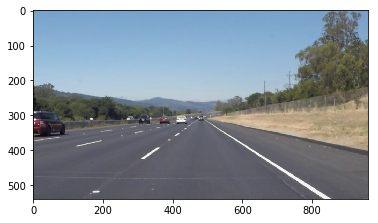

In [56]:
import os
os.listdir("test_images/")

#reading in an image
img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)

### Step 1: Image Stats

In [26]:
def stat(img):
    height, width, channel = img.shape[0], img.shape[1], img.shape[2]
    return height, width, channel

height, width, channel = stat(img)
print("Image is of type:", type(img), "height:", height, "width:", width, "channel:", channel)


Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3


### Step 2:  Gray Scale

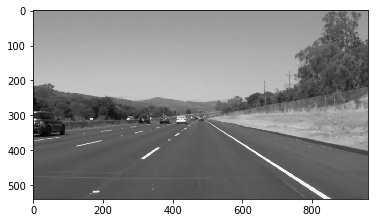

In [27]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_img = grayscale(img)
plt.imshow(gray_img, 'gray')

### Step 3: Gaussian Blur

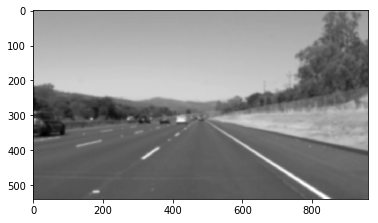

In [28]:
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (15, 15), 0)

blur_img = gaussian_blur(gray_img)
plt.imshow(blur_img, 'gray')

### Step 4: Canny Edge

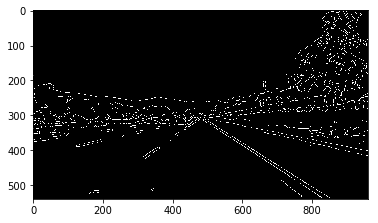

In [29]:
def canny(img):
    return cv2.Canny(img, 10, 30)

canny_edge = canny(blur_img)
plt.imshow(canny_edge, 'gray')

### Step 5: Region of Interest

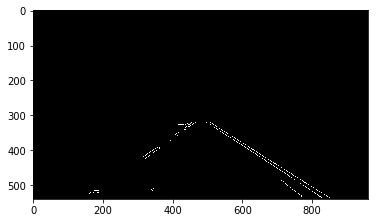

In [30]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = [np.array([[0, height], [width/2-50, height/2+50], [width/2+50, height/2+50], [width, height]], np.int32)]
masked_img = region_of_interest(canny_edge, vertices)

plt.imshow(masked_img, 'gray')

### Step 6: Hough Line

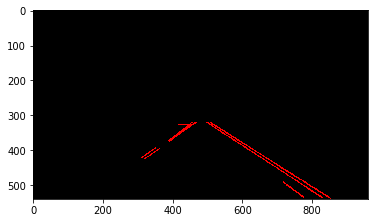

In [33]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

rho, theta, threshold, min_line_len, max_line_gap = 2, np.pi/180, 15, 40, 20
line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(line_img)

### Step 7: Annotate Lanes

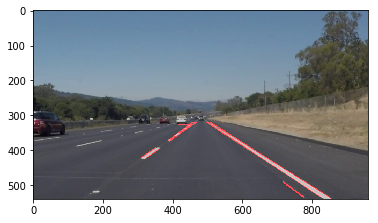

In [35]:
def annotate_lanes(img, line_img):
    return cv2.addWeighted(img, 0.8, line_img, 1.0, 0)

final = annotate_lanes(img, line_img)
plt.imshow(final)

### Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

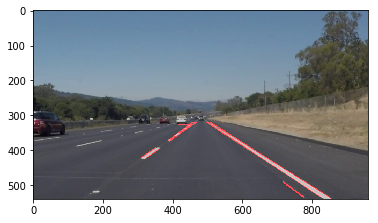

In [36]:
def pipeline(image):
    height, width, channel = image.shape[0], image.shape[1], image.shape[2]
    # convert to gray scale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # blur
    blur = cv2.GaussianBlur(gray, (15, 15), 0)
    # edge detection
    edge = cv2.Canny(blur, 10, 30)
    # mask
    mask = np.zeros_like(edge)
    vertices = np.array([[0, height], [width/2-50, height/2+50], [width/2+50, height/2+50], [width, height]], np.int32)
    cv2.fillPoly(mask, [vertices], 255)
    masked_edge = cv2.bitwise_and(edge, mask)
    # hugh transform, finding lines
    rho, theta, threshold, min_line_len, max_line_gap = 2, np.pi/180, 15, 40, 20
    lines = cv2.HoughLinesP(masked_edge, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, lines)
    # superimpose
    imposed = cv2.addWeighted(image, 0.8, line_image, 1.0, 0)
    return imposed

plt.imshow(pipeline(image))

### Videos

In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [57]:
def process_video(input_dir, output_dir):
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(input_dir)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_dir, audio=False)

# 2. Results

### Result 1: Solid White Right

In [49]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
process_video('test_videos/solidWhiteRight.mp4', white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.93 s, sys: 1.23 s, total: 5.16 s
Wall time: 8.61 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Result 2: Solid Yellow Left

In [52]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
process_video('test_videos/solidYellowLeft.mp4', yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:25<00:00, 27.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.7 s, sys: 3.8 s, total: 16.5 s
Wall time: 26.2 s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Result 3: Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [54]:
challenge_output = 'test_videos_output/challenge.mp4'
process_video('test_videos/challenge.mp4', challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:19<00:00, 13.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.68 s, sys: 2.37 s, total: 12.1 s
Wall time: 21.3 s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))